In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!unzip train.csv

Archive:  train.csv.zip
  inflating: train.csv               


In [ ]:
df=pd.read_csv('./train.csv')

In [ ]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [ ]:
#Checking whether the datset is balanced or not
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [ ]:
df.shape

(20800, 5)

In [ ]:
df=df.dropna()

In [ ]:
df.shape

(18285, 5)

In [ ]:
X=df.drop('label',axis=1)
Y=df['label']

In [ ]:
X.shape,Y.shape

((18285, 4), (18285,))

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional

In [ ]:
#vocubalry size
voc=5000

In [ ]:
messages=X.copy()
messages.reset_index(inplace=True)

In [ ]:
import nltk
import re
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Dataset preprocessing
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
corpus=[]
for i in range(0,len(messages)):
  review=re.sub('[^a-zA-Z]',' ',messages['title'][i])
  review=review.lower()
  review=review.split()
  review=[ps.stem(word) for word in review if not word in stopwords.words('english')]
  review=' '.join(review)
  corpus.append(review)

In [ ]:
#one hot representation
onehot_rep=[one_hot(word,voc)for word in corpus]

In [ ]:
onehot_rep[0]

[4378, 985, 320, 3076, 312, 1822, 1132, 2915, 3676, 3567]

In [ ]:
#Embedding Representation
sent_length=20
embedded_docs=pad_sequences(onehot_rep,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 2915 3676 3567]
 [   0    0    0 ... 2360 2332 2467]
 [   0    0    0 ... 1970  497 1568]
 ...
 [   0    0    0 ... 1816 4156 4429]
 [   0    0    0 ... 3665 3108  935]
 [   0    0    0 ... 2899 3655 3490]]


In [ ]:
embedded_docs[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 4378,
        985,  320, 3076,  312, 1822, 1132, 2915, 3676, 3567], dtype=int32)

In [ ]:
#Creating the model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc,embedding_vector_features,input_length=sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_final=np.array(embedded_docs)
Y_final=np.array(Y)

In [ ]:
X_final.shape,Y_final.shape

((18285, 20), (18285,))

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X_final,Y_final,test_size=0.33,random_state=42)

In [ ]:
#Model Training
model_history=model.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=10,batch_size=64)

Epoch 1/10
192/192 [==============================] - 36s 13ms/step - loss: 0.4622 - accuracy: 0.7515 - val_loss: 0.2057 - val_accuracy: 0.9145
Epoch 2/10
192/192 [==============================] - 2s 10ms/step - loss: 0.1357 - accuracy: 0.9492 - val_loss: 0.1998 - val_accuracy: 0.9143
Epoch 3/10
192/192 [==============================] - 2s 10ms/step - loss: 0.0914 - accuracy: 0.9685 - val_loss: 0.2709 - val_accuracy: 0.9138
Epoch 4/10
192/192 [==============================] - 2s 10ms/step - loss: 0.0515 - accuracy: 0.9841 - val_loss: 0.2930 - val_accuracy: 0.9137
Epoch 5/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0320 - accuracy: 0.9905 - val_loss: 0.3785 - val_accuracy: 0.9080
Epoch 6/10
192/192 [==============================] - 2s 10ms/step - loss: 0.0279 - accuracy: 0.9920 - val_loss: 0.3770 - val_accuracy: 0.9062
Epoch 7/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0178 - accuracy: 0.9951 - val_loss: 0.4438 - val_accuracy: 0.907

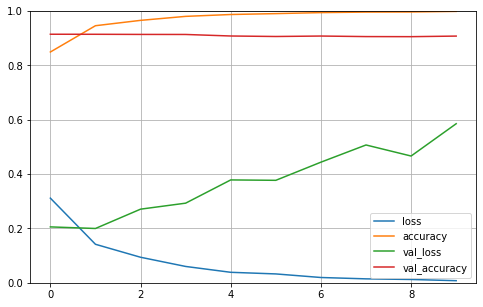

In [ ]:
pd.DataFrame(model_history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
Y_pred=model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
confusion_matrix(Y_test,Y_pred)

array([[3125,  294],
       [ 263, 2353]])

In [ ]:
accuracy_score(Y_test,Y_pred)

0.907705053852527

In [ ]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3419
           1       0.89      0.90      0.89      2616

    accuracy                           0.91      6035
   macro avg       0.91      0.91      0.91      6035
weighted avg       0.91      0.91      0.91      6035

